# Quantization of pre-trained Image Transformers

This notebook tries to establish a TIME and SPACE baseline with different quantization techiques.

* [SegFormer Part 3, Quantization Description](https://qte77.github.io/SegFormer-Part3-Quantization-Description/)
* [SegFormer Part 4, Quantization Difficulties and Errors Part 1](https://qte77.github.io/SegFormer-Part4-Quantization-Difficulties-Part1/)

# Prelims

In [79]:
try:
  from google.colab import drive
  google_colab = True
except ImportError:
  from os.path import basename
  google_colab = False

## Params

In [80]:
project_name = "SegFormer"
nb_name = "hf_segformer_quant_PoC.ipynb"

In [81]:
model_checkpoints = {
    # "swintiny": "microsoft/swin-tiny-patch4-window7-224", # not implemented
    # "b0ade": "nvidia/segformer-b0-finetuned-ade-512-512", # not implemented
    "b0": "nvidia/mit-b0"
}
# tasks = ["classification", "segmentation"] # not implemented

In [82]:
dataset_url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
ds_num_shards = 1000 # higher faster

In [83]:
batch_size = 32
num_train_epochs = 10
metric_to_load = "accuracy" # accuracy for cls, mean_iou for seg
test_calculation_speed = True

## Param prep

In [84]:
model_checkpoint = model_checkpoints['b0']
model_name = model_checkpoint.split("/")[-1]
dataset_name = dataset_url.split("/")[-1].split(".")[0]

In [85]:
from pathlib import Path
if google_colab:
  MNT_PATH = Path("/content/drive")
  SAVE_PATH = MNT_PATH / "MyDrive"
  NB_PATH = SAVE_PATH / "Colab Notebooks"
  nb_name = "hf_segformer_quant_PoC.ipynb"
else:
  SAVE_PATH = Path(".")
  NB_PATH = Path(".")
  nb_name = basename(__file__)

In [86]:
NB_PATH = NB_PATH / f"{project_name}/PoC"
DS_PATH = SAVE_PATH / f"Datasets/{dataset_name}"
MODEL_PATH = SAVE_PATH / f"Models/{model_checkpoint}"
TOK_PATH = SAVE_PATH / f"Tokenizer/{model_checkpoint}"
PY_PATH = NB_PATH / "utils"
REQS_PATH = NB_PATH / "reqs"

In [87]:
if google_colab: drive.mount(str(MNT_PATH))
NB_PATH.mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [88]:
'''reimport modules
%load_ext autoreload
%autoreload 2
'''

'reimport modules\n%load_ext autoreload\n%autoreload 2\n'

In [89]:
for req in ["requirements_quant.txt"]: #, "requirements_jupymill.txt"]:
  req_file = REQS_PATH / req
  assert req_file.exists(), "Not Again!"
  %pip install -qqr "{req_file}" -U

In [90]:
# huggingface
from datasets import load_dataset, load_from_disk
from evaluate import load
from transformers.trainer_utils import EvalPrediction
from transformers import (
  AutoImageProcessor,
  # SegformerForSemanticSegmentation,
  SegformerForImageClassification,
  TrainingArguments,
  Trainer
)

In [91]:
# tensor
from numpy import argmax
from torchinfo import summary
from torch import (
    ge, zeros,
    stack, tensor, where,
    device, no_grad # autograd.grad_mode
)
# from torch.optim import AdamW
from torchvision.transforms import (
  CenterCrop,
  Compose,
  Normalize,
  RandomHorizontalFlip,
  RandomResizedCrop,
  Resize,
  ToTensor,
)

In [92]:
# quantization
import accelerate
import bitsandbytes

In [93]:
from random import randrange
from os import chdir # , listdir

### Custom utils

In [94]:
chdir(PY_PATH)
from utils import (
    get_device_info, get_calculation_speed,
    get_split_dataset, get_image_processor,
    get_model_as_dict, print_models_stats
)

## Device

In [95]:
deviceinfo = get_device_info()
is_cuda = deviceinfo["devicename"].type == "cuda"
# assert is_cuda, "GPU needed for quantization"

In [96]:
print("cpu max memory: %s" % deviceinfo["cpu_max_memory"])
if is_cuda:
  !nvidia-smi
  print("cuda allocated memory: %s" % deviceinfo["cuda_free_mem"])
  print("cuda max memory: %s" % deviceinfo["cuda_max_memory"])
else:
  print("GPU needed for quantization")

cpu max memory: {'cpu': '12GiB'}
Tue Jun 11 22:48:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              33W /  70W |    167MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+----------------------------------

## Test calculation speed of dtypes

In [97]:
# https://pytorch.org/docs/stable/tensor_attributes.html#torch.dtype
if test_calculation_speed:
  timings = get_calculation_speed(deviceinfo["devicename"].type, tee=True)

dev='cuda'
torch.float64
mean: 0.002898, stdev: 0.001178
torch.float32
mean: 0.001703, stdev: 0.000580
torch.float16
mean: 0.002524, stdev: 0.002195
torch.bfloat16
mean: 0.002466, stdev: 0.000640
torch.int8
mean: 0.002611, stdev: 0.001402
torch.uint8
mean: 0.002033, stdev: 0.000260
torch.bool
mean: 0.003670, stdev: 0.000631
dev='cpu'
torch.float64
mean: 0.132278, stdev: 0.071404
torch.float32
mean: 0.087363, stdev: 0.021172
torch.float16
mean: 1.551432, stdev: 0.505957
torch.bfloat16
mean: 0.039436, stdev: 0.006567
torch.int8
mean: 0.419538, stdev: 0.050901
torch.uint8
mean: 0.672995, stdev: 0.228865
torch.bool
mean: 1.731381, stdev: 0.610707


# Dataset

In [98]:
dataset = get_split_dataset(str(DS_PATH), dataset_url)

In [99]:
dataset

{'train': Dataset({
     features: ['image', 'label'],
     num_rows: 24300
 }),
 'test': Dataset({
     features: ['image', 'label'],
     num_rows: 2700
 })}

In [100]:
dataset["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

In [101]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 0}

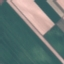

In [102]:
example['image']

In [103]:
example['label']

0

### Preprocessing the data

In [104]:
image_processor = get_image_processor(model_checkpoint, TOK_PATH)
image_processor

Loading from /content/drive/MyDrive/Tokenizer/nvidia/mit-b0.


/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


SegformerImageProcessor {
  "_valid_processor_keys": [
    "images",
    "segmentation_maps",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_reduce_labels",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [105]:
# on-the-fly image preparation and augmentation with <dataset>.set_transform(<transform_fn>)
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

dataset["train"].set_transform(preprocess_train)
dataset["test"].set_transform(preprocess_val)

In [106]:
dataset["train"][0].keys()

dict_keys(['image', 'label', 'pixel_values'])

## Ids and labels

In [107]:
labels = dataset["train"].features["label"].names
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
id2label

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

# Metric

In [108]:
metric = load(metric_to_load)

In [109]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred: EvalPrediction) -> dict:
    """Computes accuracy on a batch of predictions"""
    predictions = argmax(eval_pred.predictions, axis=1)
    return  metric.compute(
      predictions=predictions,
      references=eval_pred.label_ids
    )

# Model

## Load versions for QAT and compare SPACE/TIME

### 8-bit quantization with bitsandbytes

From [LLM.int8() Paper](https://arxiv.org/abs/2110.02861), [Source GH](https://github.com/TimDettmers/bitsandbytes).
[8-bit HF inference example](https://github.com/TimDettmers/bitsandbytes/blob/main/examples/int8_inference_huggingface.py)

* optimizer
  * `bnb.optim.Adam8bit(....)`
  * `bnb.nn.Embedding(..)`
* inference
  * `linear = bnb.nn.Linear8bitLt(...)`
  * Modes: mixed-precision, int8
  * or full `LLM.int8()` method


`BitsAndBytesConfig` also offers configuration support.

```python
from transformers import BitsAndBytesConfig

# quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=bf16)
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
)
```

In [110]:
models = {"model_base": {"params": {}}}
if is_cuda:
  models.update({
    "model_half": {"params": {"half": True}},
    "model_int8": {"params": {"load_in_8bit": True}},
    "model_int4": {"params": {"load_in_4bit": True}}
  })
models

{'model_base': {'params': {}},
 'model_half': {'params': {'half': True}},
 'model_int8': {'params': {'load_in_8bit': True}},
 'model_int4': {'params': {'load_in_4bit': True}}}

In [111]:
deviceinfo

{'devicename': device(type='cuda'),
 'cpu_max_memory': {'cpu': '12GiB'},
 'cuda_free_mem': 14,
 'cuda_n_gpus': 1,
 'cuda_max_memory': {0: '14GiB'}}

In [112]:
if is_cuda:
  max_memory = {}
  for k,v in {
      **deviceinfo["cpu_max_memory"],
      **deviceinfo["cuda_max_memory"]
    }.items():
    v = int(v.replace("GiB", ""))-2
    max_memory[k] = f"{v}GiB"
  max_memory

In [113]:
# get models
#if is_cuda:
for k,v in models.items():
  print(f"\n{k}: {v}")
  models[k] = get_model_as_dict(
    model_checkpoint, MODEL_PATH,
    max_memory, v["params"]
  )
  print(
    accelerate.infer_auto_device_map(models[k]["model"], max_memory=max_memory)
  )
  print(f"{models[k].keys()}")
#else:
#  model = ""


model_base: {'params': {}}
OrderedDict([('', 0)])
dict_keys(['load_time', 'model', 'memory_footprint'])

model_half: {'params': {'half': True}}


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


OrderedDict([('', 0)])
dict_keys(['load_time', 'model', 'memory_footprint'])

model_int8: {'params': {'load_in_8bit': True}}


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


OrderedDict([('', 0)])
dict_keys(['load_time', 'model', 'memory_footprint'])

model_int4: {'params': {'load_in_4bit': True}}
OrderedDict([('', 0)])
dict_keys(['load_time', 'model', 'memory_footprint'])


In [152]:
models_stats = {}
for k, v in models.items():
  try:
    is_quantized = models[k]['model'].is_quantized
  except:
    is_quantized = None
  models_stats[k] = {
    "load_time": v["load_time"],
    "memory_footprint": v["memory_footprint"],
    "is_quantized": is_quantized,
    "device_map": v["model"].hf_device_map
  }
models_stats

{'model_base': {'load_time': 1.4295863460001783,
  'memory_footprint': 14305568,
  'is_quantized': None,
  'device_map': {'': device(type='cuda', index=0)}},
 'model_half': {'load_time': 1.2120439969999097,
  'memory_footprint': 7152784,
  'is_quantized': True,
  'device_map': {'': device(type='cuda', index=0)}},
 'model_int8': {'load_time': 0.9208884869999565,
  'memory_footprint': 4842640,
  'is_quantized': True,
  'device_map': {'': device(type='cuda', index=0)}},
 'model_int4': {'load_time': 1.3591602530000273,
  'memory_footprint': 3687568,
  'is_quantized': True,
  'device_map': {'': device(type='cuda', index=0)}}}

In [115]:
models['model_base']['model'].config.transformers_version

'4.12.0.dev0'

In [116]:
'''
!pip install git+https://github.com/mert-kurttutan/torchview -qq
model_graph = draw_graph(models['model_base']['model'])
model_graph.visual_graph
'''

"\n!pip install git+https://github.com/mert-kurttutan/torchview -qq\nmodel_graph = draw_graph(models['model_base']['model'])\nmodel_graph.visual_graph\n"

In [117]:
models['model_base']['model'].__dir__()

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_assisted_decoding',
 '_auto_class',
 '_autoset_attn_implementation',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_beam_sample',
 '_beam_search',
 '_buffers',
 '_call_impl',
 '_check_and_enable_flash_attn_2',
 '_check_and_enable_sdpa',
 '_compiled_call_impl',
 '_constrained_beam_search',
 '_contrastive_search',
 '_convert_head_mask_to_5d',
 '_copy_lm_head_original_to_resized',
 '_create_repo',
 '_dispatch_accelerate_model',
 '_expand_inputs_for_generation',
 

## Get models memory of each layer

In [118]:
# https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
# model.state_dict()
# https://stackoverflow.com/questions/54361763/pytorch-why-is-the-memory-occupied-by-the-tensor-variable-so-small
# __sizeof__: Only the memory consumption directly attributed to the object is accounted for, not the memory consumption of objects it refers to.
# print("name, size, element_size, __sizeof__, is_quantized")
layers_mems = {}
for m in models.keys():
  layers = []
  for name, param in models[m]['model'].named_parameters():
    layers.append( (name.split(".")[-1], param.element_size() * param.numel()) )
  layers_unique = set([i[0] for i in layers])
  layers_mems[m] = {
      luniq:sum([ layer[1] for layer in layers if layer[0] == luniq])
      for luniq in layers_unique
  }
layers_mems

{'model_base': {'bias': 75680, 'weight': 14229888},
 'model_half': {'bias': 37840, 'weight': 7114944},
 'model_int8': {'bias': 37840, 'weight': 4804800},
 'model_int4': {'bias': 37840, 'weight': 3649728}}

## Print model stats

In [119]:
for m in models.keys():
  print(f"sum({m}): {(layers_mems[m]['bias']+layers_mems[m]['weight'])/(2**10)}")

sum(model_base): 13970.28125
sum(model_half): 6985.140625
sum(model_int8): 4729.140625
sum(model_int4): 3601.140625


In [120]:
print_models_stats(
  models_stats, models_stats["model_base"]["memory_footprint"]
)

name		size [MiB]	ratio	time	device_map
model_base	13.64		1.0	1.43	{'': device(type='cuda', index=0)}
model_half	6.82		0.5	1.21	{'': device(type='cuda', index=0)}
model_int8	4.62		0.34	0.92	{'': device(type='cuda', index=0)}
model_int4	3.52		0.26	1.36	{'': device(type='cuda', index=0)}


## Test model with example input

---



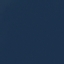

In [121]:
test_image = dataset['train'][0]['image']
inputs = image_processor(images=test_image, return_tensors="pt")
inputs["pixel_values"] = inputs["pixel_values"].to(deviceinfo["devicename"].type)
inputs_halfed = inputs.copy()
inputs_halfed["pixel_values"] = inputs_halfed["pixel_values"].half()
test_image

In [122]:
def infer_model_input_print(
    model_name: str,
    model: SegformerForImageClassification,
    input: dict
) -> None:
  print(model_name)
  with no_grad():
    outputs = model(**input)
  pred_cls_idx = outputs.logits.argmax(-1).item()
  pred_cls_lbl = model.config.id2label[pred_cls_idx]
  print(f"{outputs.keys()=}, {outputs.logits.shape=}")
  print(f"{pred_cls_idx=}, {pred_cls_lbl=}")

In [123]:
#for k in models.keys():
#  input = inputs_halfed if models[k]["model"].is_quantized else inputs
#  infer_model_input_print(k, models[k]["model"], input)

## Summary

* Different amount of non-trainable params

In [124]:
summary

<function torchinfo.torchinfo.summary(model: 'nn.Module', input_size: 'INPUT_SIZE_TYPE | None' = None, input_data: 'INPUT_DATA_TYPE | None' = None, batch_dim: 'int | None' = None, cache_forward_pass: 'bool | None' = None, col_names: 'Iterable[str] | None' = None, col_width: 'int' = 25, depth: 'int' = 3, device: 'torch.device | str | None' = None, dtypes: 'list[torch.dtype] | None' = None, mode: 'str | None' = None, row_settings: 'Iterable[str] | None' = None, verbose: 'int | None' = None, **kwargs: 'Any') -> 'ModelStatistics'>

In [125]:
# shape 2d input (C, H, W), 1d (C, L)
#TODO summary with input_size=(batch_size, 3, 512,512)) #, device='cpu')
'''
/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py
Summarize the given PyTorch model. Summarized information includes:
    1) Layer names,
    2) input/output shapes,
    3) kernel shape,
    4) # of parameters,
    5) # of operations (Mult-Adds),
    6) whether layer is trainable
'''
for m in models.keys():
  sum = summary(models[m]["model"])
  print(f"\n{m}\n{sum}")


model_base
Layer (type:depth-idx)                                                      Param #
SegformerForImageClassification                                             --
├─SegformerModel: 1-1                                                       --
│    └─SegformerEncoder: 2-1                                                --
│    │    └─ModuleList: 3-1                                                 485,472
│    │    └─ModuleList: 3-2                                                 2,832,896
│    │    └─ModuleList: 3-3                                                 1,024
├─Linear: 1-2                                                               257,000
Total params: 3,576,392
Trainable params: 3,576,392
Non-trainable params: 0

model_half
Layer (type:depth-idx)                                                      Param #
SegformerForImageClassification                                             --
├─SegformerModel: 1-1                                                       --
│

## Analysis of components

In [126]:
features = (
    "base_model_prefix", "call_super_init", "main_input_name", "classifier",
    "num_labels", "dump_patches", "is_parallelizable", "name_or_path"
)
for m in models.keys():
  print(f"\n{m}")
  for feature in features:
    model = models[m]["model"]
    f = eval(f"model.{feature}")
    print(f"{feature}:\t{f}")
del(model)


model_base
base_model_prefix:	segformer
call_super_init:	False
main_input_name:	pixel_values
classifier:	Linear(in_features=256, out_features=1000, bias=True)
num_labels:	1000
dump_patches:	False
is_parallelizable:	False
name_or_path:	nvidia/mit-b0

model_half
base_model_prefix:	segformer
call_super_init:	False
main_input_name:	pixel_values
classifier:	Linear(in_features=256, out_features=1000, bias=True)
num_labels:	1000
dump_patches:	False
is_parallelizable:	False
name_or_path:	nvidia/mit-b0

model_int8
base_model_prefix:	segformer
call_super_init:	False
main_input_name:	pixel_values
classifier:	Linear(in_features=256, out_features=1000, bias=True)
num_labels:	1000
dump_patches:	False
is_parallelizable:	False
name_or_path:	nvidia/mit-b0

model_int4
base_model_prefix:	segformer
call_super_init:	False
main_input_name:	pixel_values
classifier:	Linear(in_features=256, out_features=1000, bias=True)
num_labels:	1000
dump_patches:	False
is_parallelizable:	False
name_or_path:	nvidia/mit-b0


In [127]:
models["model_base"]["model"].__dict__.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'config', 'name_or_path', 'warnings_issued', 'generation_config', '_keep_in_fp32_modules', 'num_labels', '_is_hf_initialized', 'hf_device_map'])

### Model graph

In [128]:
# get config: print(models["model_base"]["model"]._modules[k].__dict__['config'])
# https://pytorch.org/docs/stable/generated/torch.Tensor.element_size.html
# https://pytorch.org/docs/stable/generated/torch.Tensor.numel.html#torch.Tensor.numel
'''
TODO
  named_parameters():
  pass
  #print(f"{name}")
  #print(f"\t{param.size()}, {param.element_size()}, {param.__sizeof__()}, {param.is_quantized}")
  numel()*element_size()
'''
def print_model_structure(
    modules, print_level=False, print_mem=False,
    start_level=0, max_level=99, cur_level=0
):
  '''TODO'''
  assert start_level <= max_level
  assert start_level <= cur_level
  if cur_level >= max_level: return
  lvl = f"{cur_level} " if print_level else ""
  if start_level != cur_level:
    t = " ".join(" " * cur_level)
    nl = f"{t}└ "
  else:
    nl = "- "
  for k in modules:
    print(f"{nl}{lvl}{k}")
    print_model_structure(
        modules[k]._modules, print_level, print_mem,
        start_level, max_level, cur_level+1
    )

In [129]:
modules = models["model_base"]["model"]._modules
print_model_structure(modules)

- segformer
 └ encoder
   └ patch_embeddings
     └ 0
       └ proj
       └ layer_norm
     └ 1
       └ proj
       └ layer_norm
     └ 2
       └ proj
       └ layer_norm
     └ 3
       └ proj
       └ layer_norm
   └ block
     └ 0
       └ 0
         └ layer_norm_1
         └ attention
           └ self
             └ query
             └ key
             └ value
             └ dropout
             └ sr
             └ layer_norm
           └ output
             └ dense
             └ dropout
         └ drop_path
         └ layer_norm_2
         └ mlp
           └ dense1
           └ dwconv
             └ dwconv
           └ intermediate_act_fn
           └ dense2
           └ dropout
       └ 1
         └ layer_norm_1
         └ attention
           └ self
             └ query
             └ key
             └ value
             └ dropout
             └ sr
             └ layer_norm
           └ output
             └ dense
             └ dropout
         └ drop_path
         └ lay

### Encoder `config` attributes

In [130]:
models["model_base"]["model"].base_model._modules["encoder"].\
  config.__dict__.keys()

dict_keys(['return_dict', 'output_hidden_states', 'output_attentions', 'torchscript', 'torch_dtype', 'use_bfloat16', 'tf_legacy_loss', 'pruned_heads', 'tie_word_embeddings', 'chunk_size_feed_forward', 'is_encoder_decoder', 'is_decoder', 'cross_attention_hidden_size', 'add_cross_attention', 'tie_encoder_decoder', 'max_length', 'min_length', 'do_sample', 'early_stopping', 'num_beams', 'num_beam_groups', 'diversity_penalty', 'temperature', 'top_k', 'top_p', 'typical_p', 'repetition_penalty', 'length_penalty', 'no_repeat_ngram_size', 'encoder_no_repeat_ngram_size', 'bad_words_ids', 'num_return_sequences', 'output_scores', 'return_dict_in_generate', 'forced_bos_token_id', 'forced_eos_token_id', 'remove_invalid_values', 'exponential_decay_length_penalty', 'suppress_tokens', 'begin_suppress_tokens', 'architectures', 'finetuning_task', 'id2label', 'label2id', 'tokenizer_class', 'prefix', 'bos_token_id', 'pad_token_id', 'eos_token_id', 'sep_token_id', 'decoder_start_token_id', 'task_specific_pa

### Encoder Attn W&B shapes and types

In [131]:
print("shape, type, dtype")
for m in models.keys():
  w = models[m]["model"].base_model.encoder.block[0][0].\
    attention.self.query.weight
  b = models[m]["model"].base_model.encoder.block[0][0].\
    attention.self.query.bias
  print(m)
  print(f"W: {w.shape}, {type(w)}, {w.dtype}")
  print(f"B: {b.shape}, {type(b)}, {b.dtype}")

shape, type, dtype
model_base
W: torch.Size([32, 32]), <class 'torch.nn.parameter.Parameter'>, torch.float32
B: torch.Size([32]), <class 'torch.nn.parameter.Parameter'>, torch.float32
model_half
W: torch.Size([32, 32]), <class 'torch.nn.parameter.Parameter'>, torch.float16
B: torch.Size([32]), <class 'torch.nn.parameter.Parameter'>, torch.float16
model_int8
W: torch.Size([32, 32]), <class 'bitsandbytes.nn.modules.Int8Params'>, torch.int8
B: torch.Size([32]), <class 'torch.nn.parameter.Parameter'>, torch.float16
model_int4
W: torch.Size([512, 1]), <class 'bitsandbytes.nn.modules.Params4bit'>, torch.uint8
B: torch.Size([32]), <class 'torch.nn.parameter.Parameter'>, torch.float16


### Encoder Attn W&B binarized

In [132]:
# test on single block
# https://pytorch.org/docs/stable/torch.html#math-operations
# https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
# https://pytorch.org/docs/stable/generated/torch.Tensor.map_.html
# https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html
wandb = {
  "weights": models["model_base"]["model"].base_model.encoder.\
    block[0][0].attention.self.query.weight,
  "biases": models["model_base"]["model"].base_model.encoder.\
    block[0][0].attention.self.query.bias
}
#TODO to torch.param and grad
# RuntimeError: only Tensors of floating point dtype can require gradients
wandb_binarized = {
    k:(ge(wandb[k], zeros(wandb[k].shape).to(deviceinfo["devicename"].type))*1)
    for k in wandb.keys()
}
wandb_binarized_for_softmax = {
    k:where(wandb_binarized[k].detach().clone() == 0, -1, 1)
    for k in wandb.keys()
}
print(f"{wandb=}\n{wandb_binarized=}\n{wandb_binarized_for_softmax=}")

wandb={'weights': Parameter containing:
tensor([[ 0.2056, -0.0214, -0.0157,  ..., -0.2073, -0.0188, -0.1008],
        [ 0.0999, -0.0270,  0.2822,  ..., -0.5098, -0.0323, -0.0946],
        [-0.0916, -0.1218, -0.1352,  ...,  0.0769, -0.1750, -0.1733],
        ...,
        [-0.2343, -0.2502, -0.2035,  ...,  0.3643,  0.2711, -0.1026],
        [-0.1128,  0.2950,  0.0249,  ...,  0.1715,  0.0009, -0.0659],
        [ 0.0486, -0.2077,  0.0285,  ...,  0.4297, -0.2127,  0.2493]],
       device='cuda:0', requires_grad=True), 'biases': Parameter containing:
tensor([-0.9663, -0.8828, -1.9095, -2.2925,  1.3038,  1.1518, -0.1643,  2.1551,
         1.6874,  0.0306, -2.6529, -0.1244, -2.5922,  1.1711,  0.3846,  4.2415,
         0.0925,  0.4346,  0.6358, -1.7323, -0.4298,  0.0603,  0.1595,  1.0717,
        -0.9436, -0.7558,  3.4137, -0.4830, -2.7237, -3.5547,  4.3426, -1.5543],
       device='cuda:0', requires_grad=True)}
wandb_binarized={'weights': tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..

In [133]:
# prepare full attention binarization
import re
rex = re.compile(r'.*attention.self.(?:query|key|value).(?:weight)') #|bias)')
wandb_attn = [
  n
  for n,p in models["model_base"]["model"].base_model.\
    encoder.block.named_parameters()
  if rex.findall(n)
]
wandb_attn

['0.0.attention.self.query.weight',
 '0.0.attention.self.key.weight',
 '0.0.attention.self.value.weight',
 '0.1.attention.self.query.weight',
 '0.1.attention.self.key.weight',
 '0.1.attention.self.value.weight',
 '1.0.attention.self.query.weight',
 '1.0.attention.self.key.weight',
 '1.0.attention.self.value.weight',
 '1.1.attention.self.query.weight',
 '1.1.attention.self.key.weight',
 '1.1.attention.self.value.weight',
 '2.0.attention.self.query.weight',
 '2.0.attention.self.key.weight',
 '2.0.attention.self.value.weight',
 '2.1.attention.self.query.weight',
 '2.1.attention.self.key.weight',
 '2.1.attention.self.value.weight',
 '3.0.attention.self.query.weight',
 '3.0.attention.self.key.weight',
 '3.0.attention.self.value.weight',
 '3.1.attention.self.query.weight',
 '3.1.attention.self.key.weight',
 '3.1.attention.self.value.weight']

### Encoder `named_parameters` with `requires_grad`

In [134]:
for name, param in models["model_base"]["model"].base_model.named_parameters():
  if param.requires_grad:
    print(name)

encoder.patch_embeddings.0.proj.weight
encoder.patch_embeddings.0.proj.bias
encoder.patch_embeddings.0.layer_norm.weight
encoder.patch_embeddings.0.layer_norm.bias
encoder.patch_embeddings.1.proj.weight
encoder.patch_embeddings.1.proj.bias
encoder.patch_embeddings.1.layer_norm.weight
encoder.patch_embeddings.1.layer_norm.bias
encoder.patch_embeddings.2.proj.weight
encoder.patch_embeddings.2.proj.bias
encoder.patch_embeddings.2.layer_norm.weight
encoder.patch_embeddings.2.layer_norm.bias
encoder.patch_embeddings.3.proj.weight
encoder.patch_embeddings.3.proj.bias
encoder.patch_embeddings.3.layer_norm.weight
encoder.patch_embeddings.3.layer_norm.bias
encoder.block.0.0.layer_norm_1.weight
encoder.block.0.0.layer_norm_1.bias
encoder.block.0.0.attention.self.query.weight
encoder.block.0.0.attention.self.query.bias
encoder.block.0.0.attention.self.key.weight
encoder.block.0.0.attention.self.key.bias
encoder.block.0.0.attention.self.value.weight
encoder.block.0.0.attention.self.value.bias
enco

### Encoder `patch_embeddings` attributes

In [135]:
models["model_base"]["model"].base_model._modules['encoder'].\
  _modules['patch_embeddings'].__dict__.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', '_is_hf_initialized'])

### Encoder `main_input_name`

In [136]:
models["model_base"]["model"].main_input_name

'pixel_values'

### Decoder

In [137]:
try:
  models["model_base"]["model"].decoder
except:
  print("No decoder found.")

No decoder found.


# Training

## Collation and dtype halfing of batches

In [138]:
def collate_fn(examples: dict, half_data: bool = False) -> dict:
    pixel_values = stack([example["pixel_values"] for example in examples])
    labels = tensor([example["label"] for example in examples])
    if ("trainer" in globals() and trainer.model.is_quantized) or half_data:
      pixel_values = pixel_values.half() # to fit float16 biases
    return {"pixel_values": pixel_values, "labels": labels}

In [139]:
# test collation
ds_quantized = collate_fn(dataset["train"].shard(10000, 0), True)
print(f"{ds_quantized.keys()=}\n{ds_quantized['pixel_values'].dtype=}")

ds_quantized.keys()=dict_keys(['pixel_values', 'labels'])
ds_quantized['pixel_values'].dtype=torch.float16


## Training as QAT

In [140]:
# https://huggingface.co/docs/datasets/v1.1.1/processing.html
ds_sharding = (ds_num_shards, randrange(ds_num_shards))

In [141]:
def add_args_and_trainer_to_model(model_name: str) -> None:
  """TODO"""
  # if model_name == "model_half": pass
  print(f"Adding TrainingArguments and Trainer to '{model_name}'.")
  models[model_name]["TrainArgs"] = TrainingArguments(
    f"{model_name}-finetuned-{dataset_name}",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model=metric_to_load
    # push_to_hub=True,
  )
  models[model_name]["Trainer"] = Trainer(
    models[model_name]["model"],
    models[model_name]["TrainArgs"],
    train_dataset=dataset["train"].shard(*ds_sharding),
    eval_dataset=dataset["test"].shard(*ds_sharding),
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    # optimizers=(AdamW,'')
  )

def train_model(model_name: str) -> None:
  """TODO"""
  print(f"Training '{model_name}'.")
  trainer = models[model_name]["Trainer"]
  models[model_name]["TrainResults"] = trainer.train()
  metrics = models[model_name]["TrainResults"].metrics
  # trainer.save_model()
  trainer.log_metrics("train", metrics)
  trainer.save_metrics("train", metrics)
  models[model_name]["EvalResults"] = trainer.evaluate()
  metrics = models[model_name]["EvalResults"]
  trainer.log_metrics("eval", metrics)
  trainer.save_metrics("eval", metrics)
  # trainer.save_state()
  # trainer.push_to_hub()

In [165]:
'''
if trained on quantized:
  ValueError: You cannot perform fine-tuning on purely quantized models. Please attach trainable adapters on top of the quantized model to correctly perform fine-tuning. Please see: https://huggingface.co/docs/transformers/peft for more details
'''
for k in models.keys():
  # TODO peft
  if models_stats[k]['is_quantized'] is not None:
    print(k)
    raise NotImplementedError
  add_args_and_trainer_to_model(k)
  train_model(k)

Adding TrainingArguments and Trainer to 'model_base'.
Training 'model_base'.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,8.370507,0.000000
2,No log,7.752339,0.000000
3,No log,7.283700,0.000000
4,No log,6.958632,0.000000
5,No log,6.647328,0.000000
6,No log,6.420584,0.000000
7,No log,6.287985,0.000000
8,No log,6.208805,0.000000
9,No log,6.194303,0.000000
10,1.268100,6.195221,0.000000


***** train metrics *****
  epoch                    =       10.0
  total_flos               =  3771975GF
  train_loss               =     1.2681
  train_runtime            = 0:00:16.73
  train_samples_per_second =     14.337
  train_steps_per_second   =      0.597


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =        0.0
  eval_loss               =     8.3705
  eval_runtime            = 0:00:00.07
  eval_samples_per_second =     27.056
  eval_steps_per_second   =     13.528
model_half


NotImplementedError: 

## Infer

In [168]:
for k in models.keys():
  input = inputs_halfed if models_stats[k]['is_quantized'] is not None else inputs
  infer_model_input_print(k, models[k]["model"], input)
  #print(models[k].keys())

model_base
outputs.keys()=odict_keys(['logits']), outputs.logits.shape=torch.Size([1, 1000])
pred_cls_idx=701, pred_cls_lbl='parachute, chute'
model_half
outputs.keys()=odict_keys(['logits']), outputs.logits.shape=torch.Size([1, 1000])
pred_cls_idx=701, pred_cls_lbl='parachute, chute'
model_int8
outputs.keys()=odict_keys(['logits']), outputs.logits.shape=torch.Size([1, 1000])
pred_cls_idx=398, pred_cls_lbl='abacus'
model_int4
outputs.keys()=odict_keys(['logits']), outputs.logits.shape=torch.Size([1, 1000])
pred_cls_idx=149, pred_cls_lbl='dugong, Dugong dugon'
